# Elmo - A short Tutorial


In [2]:
%matplotlib inline
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.tensorboard.plugins import projector

## Pre Trained Elmo Model:

### Loading the Elmo Model


The model trained on One Billion World Language Model Benchmark (http://www.statmt.org/lm-benchmark/) as been exposed on Tensorflow Hub. This can be loaded as :

In [ ]:
elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

We set the trainable parameter to True when creating the module so that the 4 scalar weights (as described in the paper) and all LSTM cell variables can be trained. In this setting, the module still keeps all other parameters fixed.
This will help to get the embedding of a word the model has not seen, given the context.

## Structure
The elmo model consists of two files:

**options.json** : These are the parameters/options using which the language model was trained on  <br>

**weights.hdf5** : The weights file for the best model


The input to the pre trained model (elmo) above can be fed in two different ways:

 ### 1. **Tokens**

In [ ]:
tokens_input = [["Argentina", "played", "football", "very", "well","","","",""],
                ["Brazil","is","a","strong","team","","","",""],
                ["Artists","all","over","the","world","are","attending","the","play"],
                ["Child","is","playing","the","guitar","","","",""],
                ["There","was","absolute","silence","during","the","play","",""]]

tokens_length = [5,5,9,5,7]
embeddings = elmo(inputs={"tokens": tokens_input,"sequence_len": tokens_length},
                  signature="tokens",
                  as_dict=True)["elmo"]

### 2. **Default**

In [ ]:
embeddings = elmo(["Argentina played football very well","Brazil is a strong team", 
                   "Artists all over the world are attending the play", 
                   "Child is playing the guitar", 
                   "There was absolute silence during the play"],
             signature="default",
             as_dict=True)["elmo"]

**Inputs**

The module defines two signatures: tokens and default.

With the tokens signature, the module takes tokenized sentences as input. The input tensor is a string tensor with shape [batch_size, max_length] and an int32 tensor with shape [batch_size] corresponding to the sentence length. The length input is necessary to exclude padding in the case of sentences with varying length.

In case of above Example:

    Each element contains one layer of ELMo representations with shape
    (5, 9, 1024).
     5    - the batch size
     9    - the sequence length of the batch
     1024 - the dimension of each ELMo vector

With the default signature, the module takes untokenized sentences as input. The input tensor is a string tensor with shape [batch_size]. The module tokenizes each string by splitting on spaces.




**Outputs**

The output (_embeddings_) is a dictionary with following keys:

  - word_emb: the character-based word representations with shape [batch_size, max_length, 512].
  - lstm_outputs1: the first LSTM hidden state with shape [batch_size, max_length, 1024].
  - lstm_outputs2: the second LSTM hidden state with shape [batch_size, max_length, 1024].
  - elmo: the weighted sum of the 3 layers, where the weights are trainable. This tensor has shape [batch_size, max_length, 1024]
  - default: a fixed mean-pooling of all contextualized word representations with shape [batch_size, 1024].
  
  The "elmo" value is selected.


In [ ]:
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

print("Argentina")
print(sess.run(embeddings[0][0]))

print("played")
print(sess.run(embeddings[0][1]))

print("play - Theatre")
print(sess.run(embeddings[4][6]))


### Getting the Embeddings:

Firstly, initialise the session:

        init = tf.initialize_all_variables()
        sess = tf.Session()
        sess.run(init)

The embeddings for any token can be obtained using _embeddings_ and passing the position of the token.

For Example:

**Argentina** ([0][0])

    print(sess.run(embeddings[0][0]))

**played** ([0][1])

    print(sess.run(embeddings[0][1]))
    
**play**  ([4][6])

    print(sess.run(embeddings[4][6]))


### Visualizing the Embeddings 

#### 1. **t-SNE**

In [15]:
def tsne_plot():
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    
    import tensorflow as tf
    import sys
    np.set_printoptions(threshold=sys.maxsize)

    tokens_input = [["Argentina", "played", "football", "very", "well","","","",""],
                ["Brazil","is","a","strong","team","","","",""],
                ["Artists","all","over","the","world","are","attending","the","play"],
                ["Child","is","playing","the","guitar","","","",""],
                ["There","was","absolute","silence","during","the","play","",""]]

    tokens_length = [5,5,9,5,7]
    embeddings = elmo(inputs={"tokens": tokens_input,"sequence_len": tokens_length},
                      signature="tokens",
                      as_dict=True)["elmo"]



    init = tf.initialize_all_variables()
    sess = tf.Session()
    sess.run(init)
    sent = ["Argentina", "played", "football", "very", "well"]
    sent1 = ["Brazil","is","a","strong","team"]
    sent2 = ["Artists","all","over","the","world","are","attending","the","play"]
    sent3 = ["Child","is","playing","the","guitar"]
    sent4 = ["There","was","absolute","silence","during","the","play"]
    

    for i in range(len(sent)):
        tokens.append(sess.run(embeddings[0][i]))
        labels.append(sent[i])  
    for i in range(len(sent1)):
        tokens.append(sess.run(embeddings[1][i]))
        labels.append(sent1[i])
    for i in range(len(sent2)):
        tokens.append(sess.run(embeddings[2][i]))
        labels.append(sent2[i])
    for i in range(len(sent3)):
        tokens.append(sess.run(embeddings[3][i]))
        labels.append(sent3[i])  
    for i in range(len(sent4)):
        tokens.append(sess.run(embeddings[4][i]))
        labels.append(sent4[i])
    
    tsne_model = TSNE(perplexity=6, n_components=2, init='random', n_iter=500)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(18, 12)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

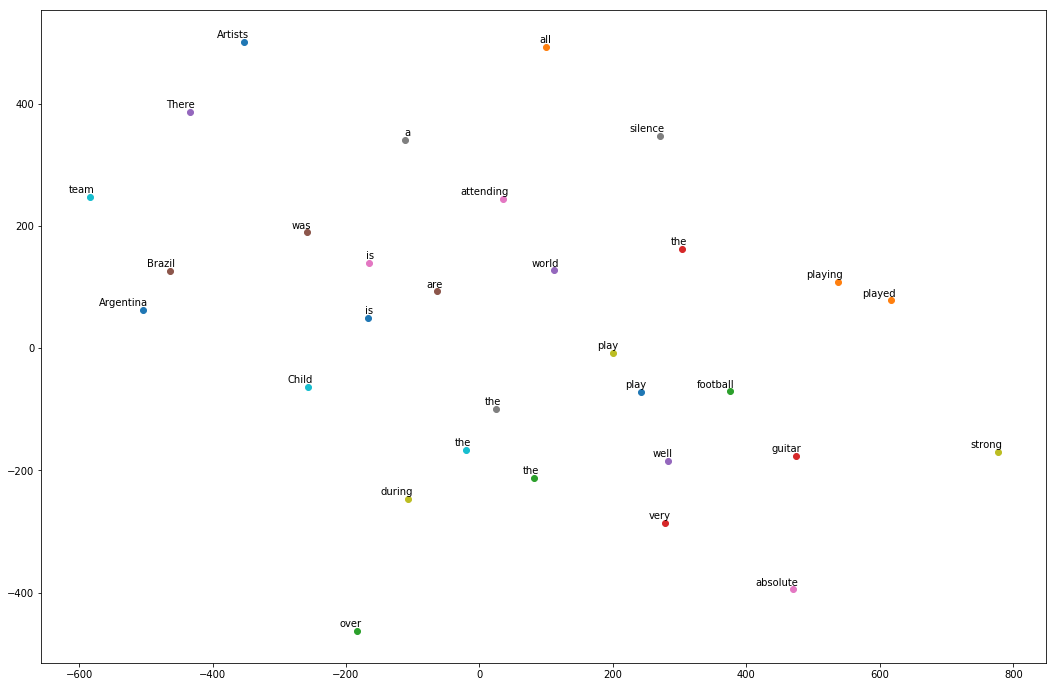

In [16]:
tsne_plot()

We see that "play" has been used in different context and Elmo is able to distinguish.

### 2. **Tensorboard**

Visualizing using Tensorboard involves the following:


- **Preparing the Batch** (embedding matrix) <br>
    
   The batch is an embedding matrix of shape **(_tokens_ , embedding dimension)** where each      entry is the embedding of the token at that position.

In [121]:
def prepare_batch():
    "Creates matrix for embeddings"
    
    sent =  ["Argentina", "played", "football", "very", "well"]
    sent1 = ["Brazil","is","a","strong","team"]
    sent2 = ["Artists","all","over","the","world","are","attending","the","play"]
    sent3 = ["Child","is","playing","the","guitar"]
    sent4 = ["There","was","absolute","silence","during","the","play"]
    
    counter=0
    batch_xs = np.zeros((31,1024)) # of shape(tokens,embedding_dimension)
    
    for i in range(len(sent)):
        batch_xs[counter] = sess.run(embeddings[0][i])
        counter = counter+1    
    counter = len(sent) 
    for i in range(len(sent1)):
        batch_xs[counter] = sess.run(embeddings[0][i])
        counter = counter+1
    counter = len(sent)+len(sent1)
    for i in range(len(sent2)):
        batch_xs[counter] = sess.run(embeddings[0][i])
        counter = counter+1
    counter = len(sent)+len(sent1)+len(sent2)
    for i in range(len(sent3)):
        batch_xs[counter] = sess.run(embeddings[0][i])
        counter = counter+1
    counter = len(sent)  
    for i in range(len(sent4)):
        batch_xs[counter] = sess.run(embeddings[0][i])
        counter = counter+1
    return batch_xs

- **Specifying the log_directory** <br>
    The log_directory is the location where you save the metadata.tsv and where all the       checkpoints will get created.
    
    
- **Creating the metadata.tsv** <br>
    This is a file which contains the index and token separated by a tab.

In [61]:
token_list = ["Argentina", "played", "football", "very", "well","Brazil","is","a","strong",
              "team","Artists","all","over","the","world","are","attending","the","play",
              "Child","is","playing","the","guitar","There","was","absolute","silence",
              "during","the","play"]

In [106]:
with open('/Users/a554755/Elmo/log_dir/Elmo_metadata.tsv','w') as f:
    f.write("Index\tLabel\n")
    for index,label in enumerate(token_list):
        f.write("%d\t%s\n" % (index,label))

In [115]:
LOG_DIR = 'log_dir'
NAME_TO_VISUALISE_VARIABLE = "elmoembedding"
TO_EMBED_COUNT = 25


#path_for_mnist_sprites =  os.path.join(LOG_DIR,'mnistdigits.png')
path_for_elmo_metadata =  os.path.join(LOG_DIR,'Elmo_metadata.tsv')

In [116]:
embedding_var = tf.Variable(batch_x, name=NAME_TO_VISUALISE_VARIABLE)
summary_writer = tf.summary.FileWriter(LOG_DIR)

In [117]:
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name

# Specify where you find the metadata
embedding.metadata_path = 'Elmo_metadata.tsv' #'metadata.tsv'

# Say that you want to visualise the embeddings
projector.visualize_embeddings(summary_writer, config)

In [118]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.save(sess, os.path.join(LOG_DIR, "model.ckpt"), 1)

'log_dir/model.ckpt-1'

### Running tensorboard :

    tensorboard --logdir="your_log_directory"
    
Tensorboard will be running at: http://localhost:6006 







# Training Elmo Model on new data:



To train and evaluate a biLM, you need to provide:

    a vocabulary file 
    a set of training files 
    a set of heldout files 

The vocabulary file is a a text file with one token per line. It must also include the special tokens <S>, </S> and <UNK> (case sensitive) in the file.

The vocabulary file should be sorted in descending order by token count in your training data. The first three lines should be the special tokens (<S>, </S> and <UNK>), then the most common token in the training data, ending with the least common token.

The training data should be randomly split into many training files, each containing one slice of the data. Each file contains pre-tokenized and white space separated text, one sentence per line. Don't include the <S> or </S> tokens in your training data.


Once done, git clone https://github.com/allenai/bilm-tf.git 
and run:

    python bin/train_elmo.py --train_prefix= <path to training folder> --vocab_file <path to vocab file> --save_dir <path where models will be checkpointed>
    
To get the weights file, run:
    
    python bin/dump_weights.py --save_dir /output_path/to/checkpoint --outfile/output_path/to/weights.hdf5
    
    
In the save dir, one options.json will be dumped and above command will give you a weights file required to create an Elmo model (options file and json file)

### To use Elmo programatically :

from allennlp.modules.elmo import Elmo, batch_to_ids

options_file = "path to options file" <br>
weight_file = "path to weights file"

elmo = Elmo(options_file, weight_file, 2, dropout=0)

2 is an integer which represents ``num_output_representations``.
Typically ``num_output_representations`` is 1 or 2.  For example, in the case of the SRL model in the above paper, ``num_output_representations=1`` where ELMo was included at
the input token representation layer.  In the case of the SQuAD model,``num_output_representations=2``as ELMo was also included at the GRU output layer.


use batch_to_ids to convert sentences to character ids:

    sentences = [['First', 'sentence', '.'], ['Another', '.']]
    character_ids = batch_to_ids(sentences)

    embeddings = elmo(character_ids)

    embeddings[elmo] is length two list of tensors. 
    Each element contains one layer of ELMo representations with shape
    (2, 3, 1024).


# Incremental Learning

In order to do the incremental learning, one would want to update an existing weights file based on new vocab file. The previously checkpointed file will have a different structure given the different vocab size. 

See: https://github.com/tensorflow/nmt/issues/134 

### The problem:
We have trained a model and created the checkpoint and have a saved weights file. We have new data with new vocab file and we create the same model structure. Now when we try to load the weights from the checkpointed file you may encounter an error:

**tensor shape mis-match** 

The most likely reason being the vocab size mis match and hence loading the weights of the embedding layer from checkpointed file(x,y) will not align with shape of the new model structure (embedding layer (m,y)) and hence will be a problem.

### Solution
Load all the layers weights except for the embedding layer and learn the weights of the embedding during the new training process.

train with the same command as above with a new parameter:

    python bin/train_elmo_updated.py --train_prefix= <path to training folder> --vocab_file <path to vocab file> --save_dir <path where models will be checkpointed> --restart_ckpt_file <path to checkpointed model>
     
replace the _training.py_ within _bilm_ with the updated _training_updated.py attached at _home_

In the _train_elmo_updated.py_ within _bin_, set these options based on your data:

    batch_size = 128  # batch size for each GPU
    n_gpus = 3

    # number of tokens in training data 
    n_train_tokens = 

    options = {
     'bidirectional': True,
     'dropout': 0.1,
     'all_clip_norm_val': 10.0,
    
     'n_epochs': 10,
     'n_train_tokens': n_train_tokens,
     'batch_size': batch_size,
     'n_tokens_vocab': vocab.size,
     'unroll_steps': 20,
     'n_negative_samples_batch': 8192,

NOTE: Try running the training on a gpu as recommended, else the training will be slow.






## Errors

Errors you may run into:

  **Cudnn_internal_status_error**<br>
  **failed to enqueue convolution/max pooling on stream** <br>
     
#### Solution
     try reducing the no. of paramters -  lesser batch size etc.
     
Kindly let me know more in the issues section if theres any.
  

### Using Elmo Embedding layer in consequent models

if you want to use Elmo Embedding layer in consequent model build refer :
https://github.com/PrashantRanjan09/WordEmbeddings-Elmo-Fasttext-Word2Vec 